# Notebook 04 — Modelagem de Clusterização de Criptomoedas
Neste notebook aplicamos técnicas de aprendizado não supervisionado para agrupar 
criptomoedas com base em suas características de risco e comportamento.

Etapas:
- Carregar features processadas
- Normalizar os dados
- Treinar K-Means (k=3)
- Avaliar clusters com Silhouette Score
- Visualizar clusters via PCA (2D)
- Salvar resultado final

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

features = pd.read_csv("../data/processed/crypto_features.csv", index_col="coin")
features.head()

,avg_return,volatility,downside_std,avg_volume,avg_marketcap,abs_return,log_volume,log_mc
coin,,,,,,,,
bitcoin,-0.005534,0.023347,0.016404,7.308600e+10,1.940580e+12,0.005534,1.000000,28.294008
cardano,-0.011261,0.039155,0.024401,1.065984e+09,1.846044e+10,0.011261,0.830991,23.638896
chainlink,-0.007330,0.040841,0.031323,8.113048e+08,1.008031e+10,0.007330,0.820077,23.033850
cosmos,-0.004907,0.051917,0.045362,8.128961e+07,1.309557e+09,0.004907,0.728107,20.992954
dogecoin,-0.005686,0.041791,0.025010,2.030098e+09,2.477025e+10,0.005686,0.856743,23.932909


## Preparação dos dados para modelagem
Inclui:
- seleção de variáveis
- normalização (StandardScaler)
- remoção de outliers (opcional)

In [22]:
# Seleção das features corretas
X_model = features[['avg_return','volatility','downside_std',
                    'abs_return','log_volume','log_mc']].copy()

# Aplicar peso ao marketcap (log_mc)
X_model['log_mc'] = X_model['log_mc'] * 5 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_model)

# Aplicando K-Means (k=3)
Escolhemos 3 clusters para representar:
- baixo risco
- risco moderado
- alto risco

In [23]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

features['cluster'] = labels
features.head()

,avg_return,volatility,downside_std,avg_volume,avg_marketcap,abs_return,log_volume,log_mc,cluster
coin,,,,,,,,,
bitcoin,-0.005534,0.023347,0.016404,7.308600e+10,1.940580e+12,0.005534,1.000000,28.294008,3
cardano,-0.011261,0.039155,0.024401,1.065984e+09,1.846044e+10,0.011261,0.830991,23.638896,0
chainlink,-0.007330,0.040841,0.031323,8.113048e+08,1.008031e+10,0.007330,0.820077,23.033850,0
cosmos,-0.004907,0.051917,0.045362,8.128961e+07,1.309557e+09,0.004907,0.728107,20.992954,1
dogecoin,-0.005686,0.041791,0.025010,2.030098e+09,2.477025e+10,0.005686,0.856743,23.932909,0


## Avaliação do modelo — Silhouette Score
Quanto mais próximo de 1, melhor a separação entre os grupos.

In [24]:
sil = silhouette_score(X_scaled, labels)
print("Silhouette Score:", sil)

Silhouette Score: 0.23237386483515002


## Redução de dimensionalidade usando PCA (2 componentes)
Permite visualizar os clusters em 2D.

In [25]:
pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)

features['pc1'] = coords[:,0]
features['pc2'] = coords[:,1]

# Visualização dos Clusters

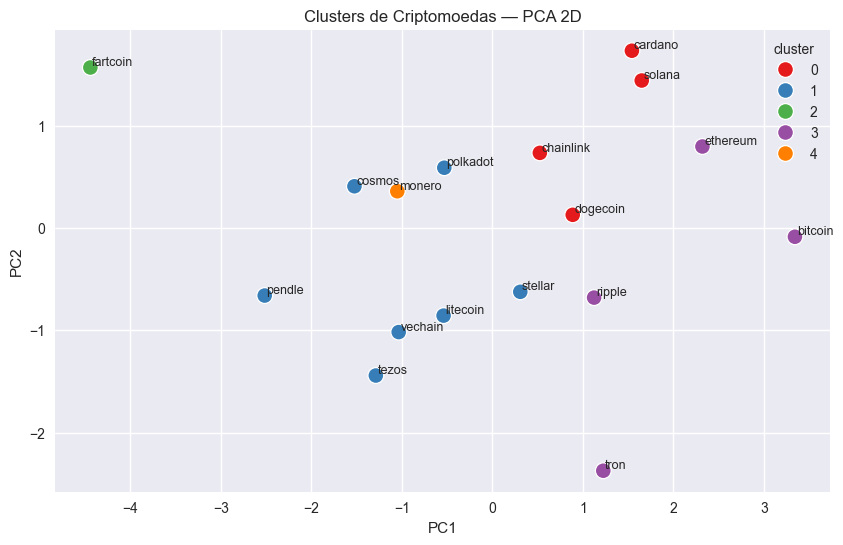

In [26]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x=features['pc1'],
    y=features['pc2'],
    hue=features['cluster'],
    palette='Set1',
    s=130
)

for coin, row in features.iterrows():
    plt.text(row['pc1']+0.02, row['pc2']+0.02, coin, fontsize=9)

plt.title("Clusters de Criptomoedas — PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

## Analisando características médias de cada cluster

In [27]:
cluster_profile = features.groupby('cluster').mean()[[
    'avg_return','volatility','downside_std','abs_return',
    'avg_volume','avg_marketcap'
]]

cluster_profile

,avg_return,volatility,downside_std,abs_return,avg_volume,avg_marketcap
cluster,,,,,,
0,-0.008282,0.040963,0.027398,0.008282,2.511709e+09,3.422669e+10
1,-0.003529,0.051004,0.031515,0.003529,2.204720e+08,3.386737e+09
2,0.004591,0.099259,0.064656,0.004591,1.263698e+08,2.851722e+08
3,-0.004086,0.028722,0.020076,0.004086,2.777869e+10,6.240819e+11
4,0.009049,0.047481,0.030987,0.009049,1.957161e+08,6.935486e+09


## Heatmap dos perfis de cluster

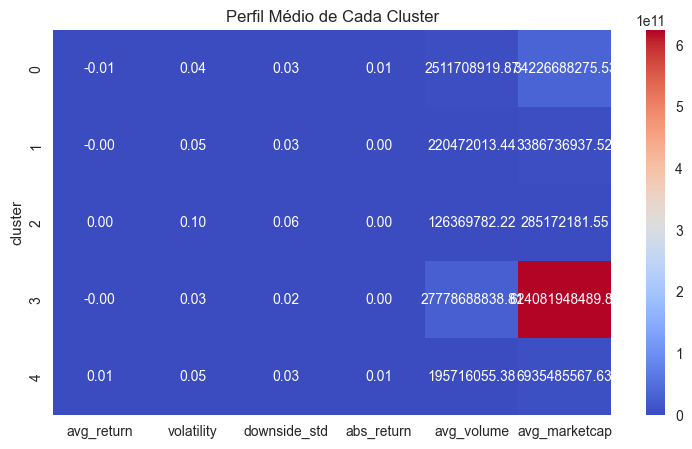

In [28]:
plt.figure(figsize=(9,5))
sns.heatmap(cluster_profile, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Perfil Médio de Cada Cluster")
plt.show()

## Teste com DBSCAN (opcional)
Pode encontrar clusters diferentes em dados densos.

In [29]:
dbscan = DBSCAN(eps=1.3, min_samples=3)
labels_db = dbscan.fit_predict(X_scaled)

features["dbscan_cluster"] = labels_db
features["dbscan_cluster"].value_counts()

dbscan_cluster
-1    13
 0     4
Name: count, dtype: int64

# Salvando os clusters para uso no Notebook 05 (Relatório Final)

In [30]:
output = "../data/outputs/crypto_clusters.csv"
features.to_csv(output)

# Mapear clusters para nomes coerentes
cluster_profile = features.groupby('cluster').agg({
    'avg_marketcap': 'mean',
    'volatility': 'mean',
    'avg_return': 'mean'
}).reset_index()

# Ordenar por marketcap para definir labels consistentes
cluster_profile = cluster_profile.sort_values(by='avg_marketcap', ascending=False)
cluster_profile['cluster_label'] = [
    'Blue Chip Estável',       # maior market cap
    'Altcoin Sólida',         # segundo maior
    'Altcoin Intermediária',   # market cap médio
    'Geminha (Projeto Pequeno Promissor)', # retorno positivo mas market cap baixo
    'Altcoin Volátil'          # risco extremo
]

# Criar dicionário de mapeamento
cluster_map = dict(zip(cluster_profile['cluster'], cluster_profile['cluster_label']))

# Aplicar ao DataFrame
features['cluster_label'] = features['cluster'].map(cluster_map)

output = "../data/outputs/crypto_clusters_renomeados.csv"
features.to_csv(output)

print("Clusters salvos em:", output)
features

Clusters salvos em: ../data/outputs/crypto_clusters_renomeados.csv


,avg_return,volatility,downside_std,avg_volume,avg_marketcap,abs_return,log_volume,log_mc,cluster,pc1,pc2,dbscan_cluster,cluster_label
coin,,,,,,,,,,,,,
bitcoin,-0.005534,0.023347,0.016404,7.308600e+10,1.940580e+12,0.005534,1.000000,28.294008,3,3.342615,-0.086766,-1,Blue Chip Estável
cardano,-0.011261,0.039155,0.024401,1.065984e+09,1.846044e+10,0.011261,0.830991,23.638896,0,1.541329,1.731144,-1,Altcoin Sólida
chainlink,-0.007330,0.040841,0.031323,8.113048e+08,1.008031e+10,0.007330,0.820077,23.033850,0,0.524519,0.732991,0,Altcoin Sólida
cosmos,-0.004907,0.051917,0.045362,8.128961e+07,1.309557e+09,0.004907,0.728107,20.992954,1,-1.524040,0.406458,-1,Geminha (Projeto Pequeno Promissor)
dogecoin,-0.005686,0.041791,0.025010,2.030098e+09,2.477025e+10,0.005686,0.856743,23.932909,0,0.887618,0.127558,0,Altcoin Sólida
ethereum,-0.006826,0.035654,0.026060,3.228336e+10,3.926658e+11,0.006826,0.967336,26.696225,3,2.320700,0.795313,-1,Blue Chip Estável
fartcoin,0.004591,0.099259,0.064656,1.263698e+08,2.851722e+08,0.004591,0.745744,19.468604,2,-4.441472,1.567333,-1,Altcoin Volátil
litecoin,-0.001777,0.052354,0.029508,8.370023e+08,7.105747e+09,0.001777,0.821324,22.684170,1,-0.539114,-0.857364,-1,Geminha (Projeto Pequeno Promissor)
monero,0.009049,0.047481,0.030987,1.957161e+08,6.935486e+09,0.009049,0.763232,22.659917,4,-1.050359,0.357839,-1,Altcoin Intermediária
